Данный проект по анализу данных выполнили студенты первого курса ФКН ПИ:
- Дюгай Андрей Владимирович
- Ермишин Никита Вячеславович




In [1]:
# подключим все необходимые библиотеки
%matplotlib inline
import seaborn as sns
from scipy.stats import norm
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [2]:
df = pd.read_csv("anime.csv")

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14578 entries, 0 to 14577
Data columns (total 18 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   title         14578 non-null  object 
 1   mediaType     14510 non-null  object 
 2   eps           14219 non-null  float64
 3   duration      9137 non-null   float64
 4   ongoing       14578 non-null  bool   
 5   startYr       14356 non-null  float64
 6   finishYr      14134 non-null  float64
 7   sznOfRelease  3767 non-null   object 
 8   description   8173 non-null   object 
 9   studios       14578 non-null  object 
 10  tags          14578 non-null  object 
 11  contentWarn   14578 non-null  object 
 12  watched       14356 non-null  float64
 13  watching      14578 non-null  int64  
 14  wantWatch     14578 non-null  int64  
 15  dropped       14578 non-null  int64  
 16  rating        12107 non-null  float64
 17  votes         12119 non-null  float64
dtypes: bool(1), float64(7), in

### 2.0. Краткое описание
Данный датасет содержит данные о различных выходивших аниме. Эти данные были собраны с сайта [anime-planet.com](https://www.anime-planet.com/) 15 июня 2020 года. Датасет был скачан с сайта [kaggle](https://www.kaggle.com/alancmathew/anime-dataset)


### 2.1 Выведем количество строк и столбцов

In [4]:
df.shape

(14578, 18)

### 2.2 - 2.4 Название, типы и описание переменных
Не типизируемы:
 - title - название
 - description - описание
 
Категориальные (номинальные):
 - mediaType - тип
 - sznOfRelease - время года выпуска сезона
 - studios - студии, учавствовавшие в создание
 - tags - жанры
 - contentWarn - ограничения

Категориальные (бинарные):
 - ongoing - не вышло полностью

Интервальные:
 - startYr - год начала показа
 - finishYr - год конца показа
 - rating - средняя оценка

Абсолютные: 
 - eps - количество эпизодов
 - duration - продолжительность эпизода - *минуты*
 - watched - количество просмотревших людей
 - watching - количество смотрящих людей
 - wantWatch - количество желающих просмотреть
 - dropped - количество людей, не досмотревших до конца 
 - votes - количество оценок

### 2.5 Тип данных в колонке

In [5]:
df.dtypes

title            object
mediaType        object
eps             float64
duration        float64
ongoing            bool
startYr         float64
finishYr        float64
sznOfRelease     object
description      object
studios          object
tags             object
contentWarn      object
watched         float64
watching          int64
wantWatch         int64
dropped           int64
rating          float64
votes           float64
dtype: object

### 2.6 Число пустых значений

In [6]:
df.isna().sum()

title               0
mediaType          68
eps               359
duration         5441
ongoing             0
startYr           222
finishYr          444
sznOfRelease    10811
description      6405
studios             0
tags                0
contentWarn         0
watched           222
watching            0
wantWatch           0
dropped             0
rating           2471
votes            2459
dtype: int64

### 3. Изменим типы данных в столбцах на более подходящие
- **watched** переводим из *float64* в *int64*
- **startYr** и **finishYr** переводим из *float64* в *datetime64[ns]*
- **rating** заменяем *NaN* на *0*
- **votes** заменяем *NaN* на *0* и переводим из *float64* в *int64*

In [7]:
df["watched"] = df["watched"].fillna(0).astype("int64")

df["startYr"].dropna()
df["startYr"] = pd.to_datetime(df["startYr"], format="%Y")

df["finishYr"].dropna()
df["finishYr"] = pd.to_datetime(df["finishYr"], format="%Y")

df["rating"] = df["rating"].fillna(0)

df["votes"] = df["votes"].fillna(0).astype("int64")

In [8]:
df.dtypes

title                   object
mediaType               object
eps                    float64
duration               float64
ongoing                   bool
startYr         datetime64[ns]
finishYr        datetime64[ns]
sznOfRelease            object
description             object
studios                 object
tags                    object
contentWarn             object
watched                  int64
watching                 int64
wantWatch                int64
dropped                  int64
rating                 float64
votes                    int64
dtype: object

### 4. Рассчитаем новые столбцы с данными на основе существующих.
- **totalInvolvement** - общее количество вовлеченных людей - сумма смотревших, смотрящих, желающих просмотреть и бросивших просмотр;
- **droppedNormalized** - частное количество людей, бросивших просмотр, к количеству вовлеченных людей;
- **isDrama** - обозначает наличие тега драма в списке тегов;

In [9]:
df["totalInvolvement"] = df["watched"] + df["watching"] + df["wantWatch"] + df["dropped"]
df["droppedNormalized"] = df["dropped"] / df["totalInvolvement"]
df["isDrama"] = df["tags"].apply(lambda x: 'Drama' in x)

### 5. Разбиваем интервальную переменную **startYr** на группы.
- *1970s and earlier* - 1980 год и ранее
- *1980s* - с 1981 по 1990 год
- *1990s* - с 1991 по 2000 год
- *2000s* - с 2001 по 2010 год
- *2010s* - с 2011 по 2020 год
- *2020s* - с 2021 по 2030 год

Данное разбиение выбрано в силу того, что оно позволяет проще оценить отличия аниме разных десятилетий, и сделать это наиболее корректно.

In [10]:
def categorize(year):
  data = [([0, 1980], "1970s and earlier"), ([1981, 1990], "1980s"), ([1991, 2000], "1990s"), ([2001, 2010], "2000s"), ([2011, 2020], "2010s"), ([2021, 2030], "2020s")]
  for t in data:
    if (year >= t[0][0] and year <= t[0][1]):
      return t[1]

df["decade"] = ""

for index, row in df.iterrows():
  df.iloc[index, list(df.columns).index("decade")] = categorize((row["startYr"].year + row["finishYr"].year) // 2)

### 6. Формируем срез по таблице и транспонируем его.
Сформировали срез по всему аниме студии *David Production*, содержащему *JoJo* в названии.

In [11]:
JoJo_index = []

for i, row in df.iterrows():
  if 'David Production' in row['studios']:
    if 'JoJo' in row['title']:
      JoJo_index.append(i)

df.loc[JoJo_index].T

,43,83,87,256,295,775,6600
title,JoJo's Bizarre Adventure: Golden Wind,JoJo's Bizarre Adventure: Diamond is Unbreakable,JoJo’s Bizarre Adventure: Stardust Crusaders -...,JoJo's Bizarre Adventure: Stardust Crusaders,JoJo's Bizarre Adventure (2012),JoJo's Bizarre Adventure Re-Edited,JoJo's Bizarre Adventure: Golden Wind Recaps
mediaType,TV,TV,TV,TV,TV,TV Special,TV Special
eps,39.0,39.0,24.0,24.0,26.0,3.0,3.0
duration,NaN,NaN,NaN,NaN,NaN,105.0,NaN
ongoing,False,False,False,False,False,False,False
startYr,2018-01-01 00:00:00,2016-01-01 00:00:00,2015-01-01 00:00:00,2014-01-01 00:00:00,2012-01-01 00:00:00,2014-01-01 00:00:00,2019-01-01 00:00:00
finishYr,2019-01-01 00:00:00,2016-01-01 00:00:00,2015-01-01 00:00:00,2014-01-01 00:00:00,2013-01-01 00:00:00,2014-01-01 00:00:00,2019-01-01 00:00:00
sznOfRelease,Fall,Spring,Winter,Spring,Fall,NaN,NaN
description,Giorno Giovanna is a young man that lives in N...,It has been 11 years since the defeat of the J...,"After 30 days of travel across the world, plag...",In a Japanese jail sits 17-year-old Jotaro Kuj...,"When Jonathan Joestar was just a baby, his mot...","A re-edited, re-telling of JoJo's Bizarre Adve...","Recap episodes, covering episodes 1-13, 14-21,..."
studios,['David Production'],['David Production'],['David Production'],['David Production'],['David Production'],['David Production'],['David Production']


### 7. Отсортируем значения по полям **rating** и **totalInvolvement**.


In [12]:
df.sort_values(['rating', 'totalInvolvement'], ascending=[False, False])[['title','rating', 'totalInvolvement']].head(20)

,title,rating,totalInvolvement
0,Fullmetal Alchemist: Brotherhood,4.702,146524
1,your name.,4.663,82141
2,A Silent Voice,4.661,64118
3,Haikyuu!! Karasuno High School vs Shiratorizaw...,4.660,35566
4,Attack on Titan 3rd Season: Part II,4.650,32563
5,Demon Slayer: Kimetsu no Yaiba,4.647,53308
6,Haikyuu!! Second Season,4.639,44118
7,Hunter x Hunter (2011),4.635,89276
8,Gintama Kanketsu-hen: Yorozuya yo Eien Nare,4.625,15508
9,Gintama (2015),4.622,22228


### 8. Формируем гипотезы.
1. Чем больше рейтинг аниме, тем больше людей в нём заинтересованных
2. Людей, которые смотрят онгоинги меньше чем тех, кто смотрит уже вышедшее аниме
3. Большинство фильмов имеют тег "Драма"
4. Чем больше людей посмотрело, тем больше хотят посмотреть
5. Чем больше эпизодов, тем больше людей перестало смотреть (в процентном отношении ко всем вовлеченным)

### 9. Строим графики.

<AxesSubplot:title={'center':'Точечная диаграмма рейтинга и заинтересованности'}, xlabel='rating', ylabel='totalInvolvement'>

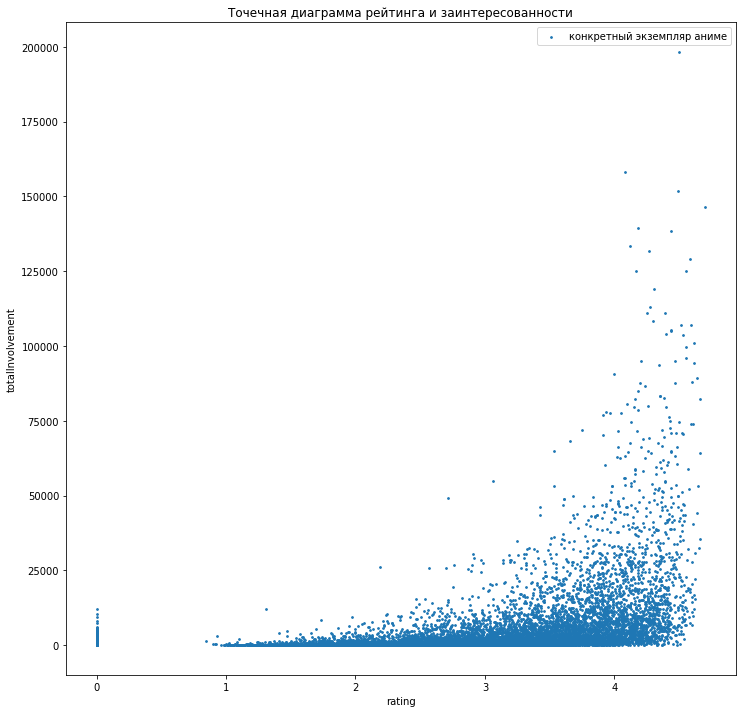

In [13]:
df.plot.scatter(x = "rating", 
                y = "totalInvolvement",
                s = 3,
                title = 'Точечная диаграмма рейтинга и заинтересованности',
                label='конкретный экземпляр аниме',
                legend = True, 
                figsize=(12, 12))

Благодаря точечной диаграмме рейтинга и заинтересованности можно легко заметить, что аниме обладающие наибольшей заитересованностью у зрителей имеют больший рейтинг [1].

<AxesSubplot:title={'center':'Точечная диаграмма количества просмотревших и желающих'}, xlabel='watched', ylabel='wantWatch'>

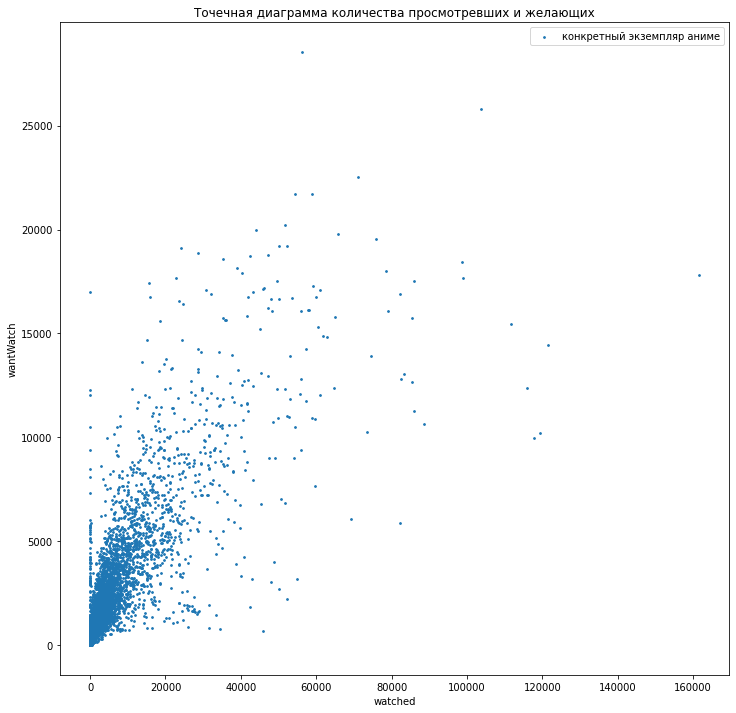

In [14]:
df.plot.scatter(x = "watched", 
                y = "wantWatch",
                s = 3,
                title = 'Точечная диаграмма количества просмотревших и желающих',
                label='конкретный экземпляр аниме',
                legend = True,
                figsize=(12, 12))

Благодаря точечной диаграмме количества просмотревших и желающих можно легко заметить, что чем меньше просмотров аниме, тем меньше желающих его посмотреть. Однако, можно заметить ряд точек около оси watched=0, которые показывают, что существует достаточно аниме, которые смотрело очень мало людей, но очень много хотят посмотреть [4]

C:\Users\ermni\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


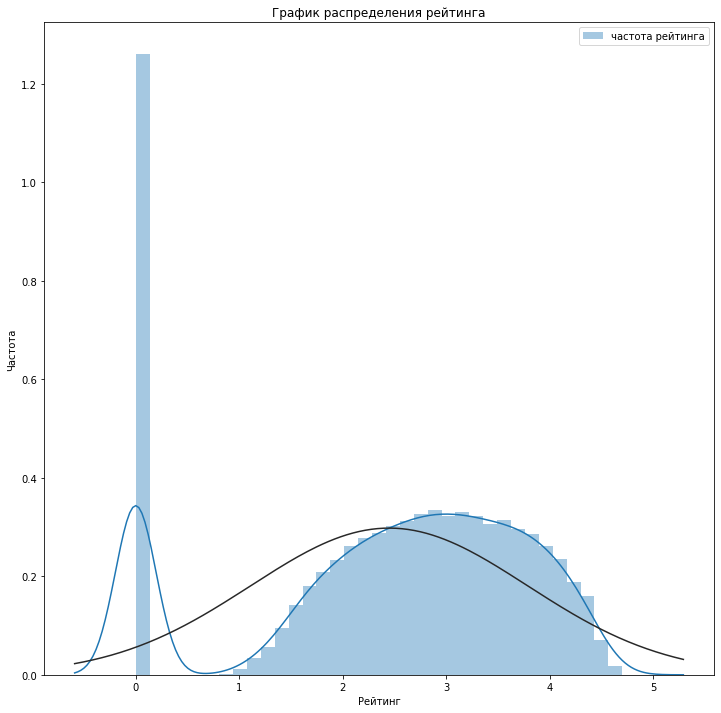

In [15]:
fig, ax = plt.subplots()
fig.set_size_inches(12, 12)
sns.distplot(df['rating'], fit=norm, label="частота рейтинга")
plt.title("График распределения рейтинга")
plt.xlabel("Рейтинг")
plt.ylabel("Частота") 
plt.xlabel("Рейтинг")
plt.legend()

С помощью графика распределения рейтинга можно понять, что существует смещение рейтинга в большую сторону относительно нормального распределения.

Также можно заметить большой столб на оси rating=0. Это можно объяснить тем, что часто люди ставят оценку 0 на то, что им совершенно не нравится.

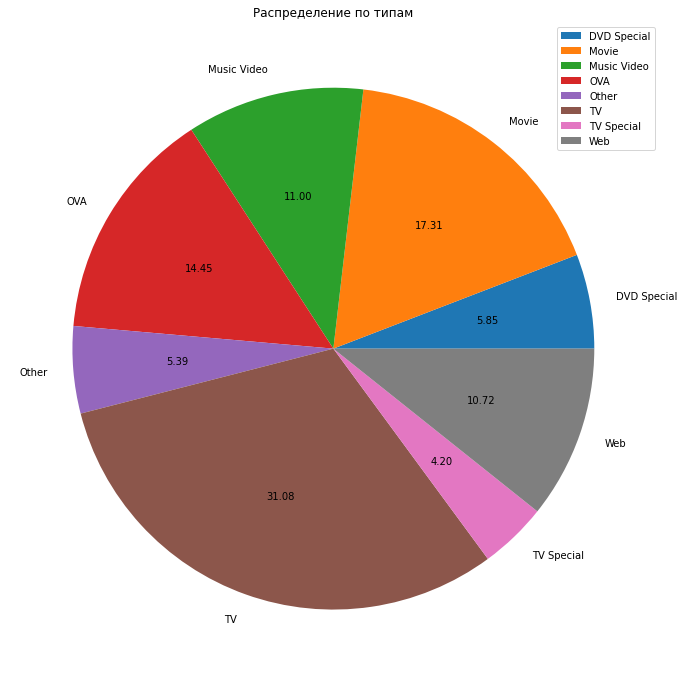

In [16]:
df.groupby('mediaType').size().plot(kind='pie', title='Распределение по типам', ylabel = '', autopct='%.2f', figsize=(12, 12)).legend(loc='upper right')

С помощью круговой диаграммы распределения по типам можно понять, что более половины аниме представлено в типах 'TV', 'Movie', 'OVA'.

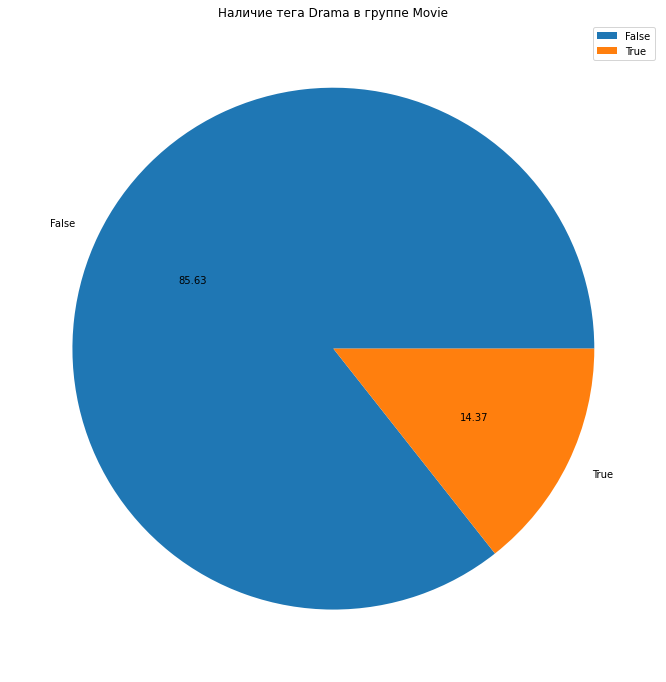

In [17]:
df[df["mediaType"] == 'Movie'].groupby('isDrama').size().plot(kind='pie', title='Наличие тега Drama в группе Movie', ylabel = '', autopct='%.2f', figsize=(12, 12)).legend(loc='upper right')

С помощью круговой диаграммы наличия тега Drama в группе Movie можно понять, что большая часть аниме в группе Movie не имеет тега Drama [3].

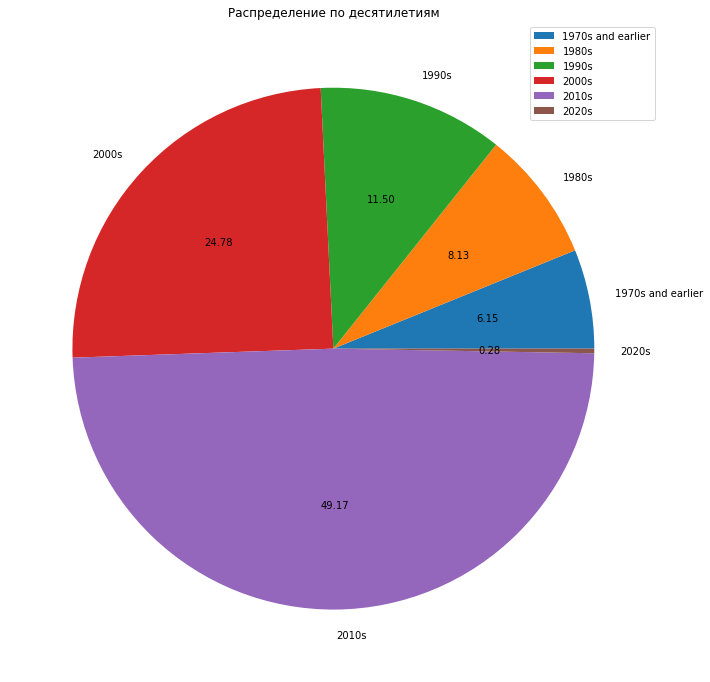

In [18]:
df.groupby('decade').size().plot(kind='pie', title='Распределение по десятилетиям', ylabel = '', autopct='%.2f', figsize=(12, 12)).legend(loc='upper right')

С помощью круговой диаграммы распределения по десятилетиям можно понять, что с каждым десятилетием количество аниме увеличивается, однако в категории '2020s' еще не так много аниме в силу того, что датасет был собран в 2020 году.

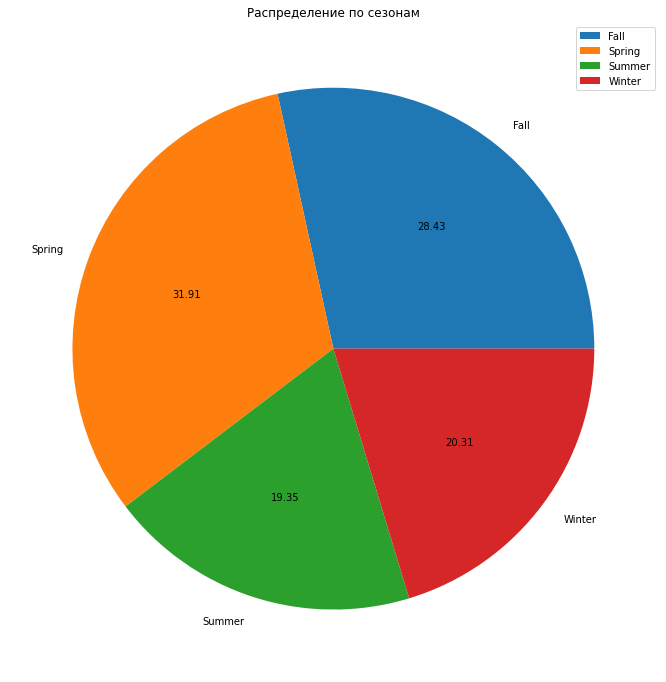

In [19]:
df.groupby('sznOfRelease').size().plot(kind='pie', title='Распределение по сезонам', ylabel = '', autopct='%.2f', figsize=(12, 12)).legend(loc='upper right')

С помощью круговой диаграммы распределения по сезонам можно понять, что большая часть аниме (60%) выходит весной и осенью

### 10. Строим сводные таблицы.

In [20]:
pd.pivot_table(df, columns=["mediaType"], index=["ongoing"], values=["watching"], dropna=True)

watching                                                \
mediaType DVD Special      Movie Music Video         OVA      Other   
ongoing                                                               
False       44.255042  25.210987    1.304511   72.394346  12.422627   
True        25.166667        NaN         NaN  755.400000  67.153846   

                                              
mediaType           TV TV Special        Web  
ongoing                                       
False       570.128850  25.763636  38.970588  
True       2418.446809  23.500000  73.516129

Из вышепреведенной сводной таблицы можно понять, что:

1) В среднем онгоинги смотрят больше, т.к уже вышедшее аниме уже было просмотрено большим количеством людей [2]

2) Не существует онгоингов в категориях 'Movie' и 'Music Video', так как они не выпускаются сериями

3) Онгоинги типа 'DVD Special' проигрывают уже вышедшим аниме (скорее всего в силу убывающей популярности формата DVD)

In [21]:
pd.pivot_table(df, columns=["mediaType"], index=["decade"], values=["totalInvolvement", "watched"], dropna=True)

totalInvolvement                                        \
mediaType              DVD Special        Movie Music Video          OVA   
decade                                                                     
1970s and earlier              NaN   225.618102   31.075758    29.666667   
1980s                    39.666667  2066.758308   30.108434   752.406154   
1990s                  1217.833333  4663.182965  322.442857  1572.153481   
2000s                  2792.647590  6026.457926  342.308000  3841.709416   
2010s                  1982.386364  2851.398585  142.897687  3558.736735   
2020s                          NaN   290.153846         NaN          NaN   

                                                                        \
mediaType                Other            TV   TV Special          Web   
decade                                                                   
1970s and earlier   130.000000    540.298246    95.242424          NaN   
1980s               295.375000   1178.979798   720.891892    18.500000   
1990s               643.651163   4906.479212  2380.164179   811.000000   
2000s              1299.084416  11852.509105  3457.250000  1266.194737   
2010s               576.540948   8844.633069  2017.382239   595.992742   
2020s                      NaN   1393.851852          NaN          NaN   

                       watched                                        \
mediaType          DVD Special        Movie Music Video          OVA   
decade                                                                 
1970s and earlier          NaN   147.975717   19.833333    12.500000   
1980s                18.333333  1639.299094   19.578313   459.123077   
1990s               841.458333  3850.823344  232.928571  1028.238924   
2000s              1974.641566  4715.882583  250.092000  2630.016234   
2010s              1287.803719  1583.476415  103.068505  2250.432653   
2020s                      NaN     0.000000         NaN          NaN   

                                                                     
mediaType               Other           TV   TV Special         Web  
decade                                                               
1970s and earlier   80.818182   298.954386    47.575758         NaN  
1980s              199.125000   752.188552   595.472973    5.000000  
1990s              468.744186  3354.159737  1835.104478  604.000000  
2000s              919.655844  7565.951702  2572.680233  765.557895  
2010s              343.808190  5265.211023  1387.957529  322.790323  
2020s                     NaN     0.000000          NaN         NaN

Из вышепреведенной сводной таблицы можно понять, что:

1) Аниме, выпущенное в '2010s' пользуется меньшим спросом чем то, которое было выпущено в '2000s'.

2) Аниме данного датасета, выпущенное в '2020s' нельзя считать репрезентативной группой, поскольку на момент сбора датасета не все типы аниме попали в выборку и не успело пройти достаточно времени.

In [22]:
pd.pivot_table(df, columns=["sznOfRelease"], index=["ongoing"], values=["totalInvolvement"], dropna=True, aggfunc=np.sum)

totalInvolvement                            
sznOfRelease             Fall    Spring   Summer   Winter
ongoing                                                  
False                10852186  10982684  6881300  6389496
True                   160492    164741     5089    44726

Из вышепреведенной сводной таблицы можно понять, что:

1) Больше людей заинтересованных в аниме, выходящем весной и осенью (т.к. весной и осенью выходит больше аниме)

### 11. Рассчитаем описательные статистики.

In [23]:
display(df[["rating"]].describe(), df[["rating"]].mode())

,rating
count,14578.000000
mean,2.448887
std,1.339006
min,0.000000
25%,1.795000
50%,2.708000
75%,3.479000
max,4.702000


,rating
0,0.0


Рейтинг достаточно сильно варьируется. Можно заметить, что мода - 0 (что совпадает с графиками, приведенными выше).

Так как медиана больше среднего арифметического, можн заметить смещение распределения в сторону большего рейтинга.

In [24]:
display(df.groupby("mediaType")["rating"].describe(), df.groupby("mediaType")[["rating"]].apply(lambda x: x.mode()), df.groupby("mediaType")[["rating"]].std())

,count,mean,std,min,25%,50%,75%,max
mediaType,,,,,,,,
DVD Special,849.0,2.897441,0.945459,0.0,2.47800,3.0290,3.5370,4.501
Movie,2512.0,2.360591,1.515931,0.0,1.36050,2.7465,3.6310,4.663
Music Video,1596.0,1.921798,1.095842,0.0,1.51375,2.1175,2.6950,4.392
OVA,2097.0,2.534664,1.292140,0.0,2.04700,2.7870,3.4990,4.539
Other,782.0,1.871698,1.265645,0.0,0.00000,2.1030,2.7825,4.433
TV,4510.0,2.831034,1.249719,0.0,2.34950,3.1095,3.7360,4.702
TV Special,609.0,2.599900,1.336488,0.0,2.20500,2.9560,3.5780,4.545
Web,1555.0,1.887202,1.307807,0.0,1.02550,2.0160,2.8790,4.540


,,rating
mediaType,,
DVD Special,0,0.0
Movie,0,0.0
Music Video,0,0.0
OVA,0,0.0
Other,0,0.0
TV,0,0.0
TV Special,0,0.0
Web,0,0.0


,rating
mediaType,
DVD Special,0.945459
Movie,1.515931
Music Video,1.095842
OVA,1.292140
Other,1.265645
TV,1.249719
TV Special,1.336488
Web,1.307807


Рейтинг группы TV в среднем выше, чем рейтинг группы Movie.

Жанры TV и DVD Special превосходят остальные по среднему и медианному значению рейтинга, а группы Music Video, Other и Web наоборот показывают явное отставание от остальных жанров.

В группах DVD special и Music Video наблюдается наименьшее отклонение, в то время как жанру Movie соответствует наибольшее отклолнение рейтинга.

### 12. Посчитайем корреляции между числовыми данными.

In [25]:
df.corr()

,eps,duration,ongoing,watched,watching,wantWatch,dropped,rating,votes,totalInvolvement,droppedNormalized,isDrama
eps,1.000000,-0.056919,0.156691,0.030398,0.169180,0.038773,0.156563,0.018648,0.061656,0.058549,0.213330,-0.009845
duration,-0.056919,1.000000,-0.065079,0.299092,0.046459,0.363767,0.034972,0.297581,0.289717,0.322473,-0.074803,0.207539
ongoing,0.156691,-0.065079,1.000000,-0.041420,0.086826,-0.022910,0.006216,-0.064307,-0.024468,-0.023230,0.056789,-0.011213
watched,0.030398,0.299092,-0.041420,1.000000,0.447612,0.822131,0.654912,0.351477,0.982885,0.977149,0.020798,0.107764
watching,0.169180,0.046459,0.086826,0.447612,1.000000,0.518531,0.751821,0.187134,0.586341,0.591789,0.114302,0.088320
wantWatch,0.038773,0.363767,-0.022910,0.822131,0.518531,1.000000,0.678279,0.444458,0.840639,0.898459,0.090988,0.196793
dropped,0.156563,0.034972,0.006216,0.654912,0.751821,0.678279,1.000000,0.246601,0.750585,0.754030,0.289114,0.097439
rating,0.018648,0.297581,-0.064307,0.351477,0.187134,0.444458,0.246601,1.000000,0.339559,0.381408,0.049390,0.148289
votes,0.061656,0.289717,-0.024468,0.982885,0.586341,0.840639,0.750585,0.339559,1.000000,0.990813,0.051124,0.115441
totalInvolvement,0.058549,0.322473,-0.023230,0.977149,0.591789,0.898459,0.754030,0.381408,0.990813,1.000000,0.062029,0.134866


Количество эпизодов имеет слабую прямую корреляцию с нормализованным количеством бросивших просмотр.

Продолжительность эпизода имеет слабую прямую корреляцию с количеством заинтересованных людей.

Параметр онгоинг имеет слабую прямую взаимосвязь с количеством эпизодов (т.к. онгоинги - сериалы).

Существует **сильная** прямая корреляция между количеством просмотревших и количеством желающих просмотреть и средняя корреляция между количеством смотрящих и количеством просмотревших. [4]

Рейтинг имеет среднюю прямую корреляцию с количеством посмотревших, желающих посмотреть и общим числом заинтересованных [1].

Очевидно, что количество голосов имеет почти полную прямую корреляцию с количеством вовлеченных.

### 13. Формулируем выводы.

### Общие:
В результате анализа мы поняли, что из десятилетия в десятилетие жанр аниме развивается. Со сменой декад развиваются технология и сменяются источники информации, но несмотря на это продолжается бурное развитие индустрии аниме.

### По гипотезам:
1. ✅ Чем больше рейтинг аниме, тем больше людей в нём заинтересованных (имеется средняя прямая корреляция)
2. ❌ Людей, которые смотрят онгоинги меньше чем тех, кто смотрит уже вышедшее аниме (В среднем онгоинги смотрят больше, т.к уже вышедшее аниме уже было просмотрено большим количеством людей)
3. ❌ Большинство фильмов имеют тег "Драма"
4. ✅ Чем больше людей посмотрело, тем больше хотят посмотреть (имеется сильная прямая корреляция)
5. ✅ Чем больше эпизодов, тем больше людей перестало смотреть (в процентном отношении ко всем вовлеченным) (имеется слабая прямая корреляция)


*Факт подтверждения гипотезы n можно найти в работе по примечанию [n]*

# ВТОРАЯ ЧАСТЬ ЗАДАНИЯ

In [26]:
import requests
from bs4 import BeautifulSoup
import pandas as pd

In [27]:
url = 'https://distrowatch.com/dwres.php?resource=ranking&sort=average10'
a = requests.get(url)

In [28]:
page = BeautifulSoup(a.text, 'html.parser')
page

<!DOCTYPE HTML PUBLIC "-//W3C//DTD HTML 4.01 Transitional//EN" "http://www.w3.org/TR/html4/loose.dtd">
<html><head>
<title>DistroWatch.com: Put the fun back into computing. Use Linux, BSD.</title>
<meta content="text/html; charset=utf-8" http-equiv="content-type"/>
<meta content="News and feature lists of Linux and BSD distributions." name="description"/>
<meta content="distrowatch, linux, android, bsd, unix, distro, distros, distributions, ubuntu, debian, suse, opensuse, fedora, red hat, centos, mageia, knoppix, gentoo, slackware, freebsd, openbsd" name="keywords"/>
<meta content="DistroWatch" name="author"/>
<!-- <link rel="stylesheet" type="text/css" href="http://fonts.googleapis.com/css?family=Lato:400,700,400italic,700italic" />
<link rel="stylesheet" type="text/css" href="http://fonts.googleapis.com/css?family=Ubuntu:regular,italic,bold,bolditalic&amp;subset=Latin" />-->
<link href="news/dw.xml" rel="alternate" title="DistroWatch: Latest News" type="application/rss+xml"/>
<link h

In [29]:
def parse_main_info(page):
    d = {}
    d['name'] = page.h1.get_text()
    for li in list(page.findAll('table')[6].findAll('tr')[1].findAll('ul')[0].find_all('li'))[::-1]:
        text = li.get_text().split(':')
        label = text[0].strip()
        data = [i.strip() for i in text[1].split(',')]
        data = (data if (label.lower() in ['category', 'desktop', 'architecture', 'based on']) else data[0]) #FIX
        if label != 'Popularity':
            d[label.lower()] = data
        li.extract()

    return d


def parse_pop_n_rating(page, status):
    d = {}
    d['rating'] = float(page.findAll('table')[5].findAll('b')[-2].text)
    d['votes'] = int(page.findAll('table')[5].findAll('b')[-1].text)

    if not ('Active' in status):
        return d
    for raw in page.findAll('table')[5].get_text().split('Popularity (hits per day):')[-1].split('Average visitor rating')[0].split(', '):
        text = raw.replace(',', '').split(':')
        label = text[0].strip()
        #print(text[1])
        popularity = int(text[1].strip().split(' ')[0].strip())
        hpd = int(text[1].strip().split(' ')[1][1:-1])
        d['popularity ' + label] = popularity
        d['avg hpd ' + label] = hpd

    return d

In [30]:
l = []
for i, tr in enumerate(page.find_all('table')[8].find_all('tr')[1:]):
    sub_url = tr.find_all('td')[1].a['href']
    b = requests.get('https://distrowatch.com/'+ sub_url)
    sub_page = BeautifulSoup(b.text, 'html.parser')
    d_info = parse_main_info(sub_page)
    d_pop_n_rating = parse_pop_n_rating(sub_page, d_info['status'])
    data = dict(d_info, **d_pop_n_rating)
  
    l.append(data)
df = pd.DataFrame(l)
df

,name,status,category,desktop,architecture,origin,based on,os type,rating,votes,popularity 12 months,avg hpd 12 months,popularity 6 months,avg hpd 6 months,popularity 3 months,avg hpd 3 months,popularity 4 weeks,avg hpd 4 weeks,popularity 1 week,avg hpd 1 week
0,Linux From Scratch,Active,"[Source-based, Education]","[Fluxbox, IceWM, KDE Plasma, LXDE, Openbox, Xfce]","[i386, x86_64]",Canada,[Independent],Linux,9.91,11,131.0,72.0,121.0,77.0,146.0,53.0,134.0,57.0,128.0,57.0
1,Bedrock Linux,Active,[Specialist],[No Desktop],"[aarch64, armv7, i386, mips64, mipsel, ppc, pp...",USA,[Independent],Linux,9.80,15,162.0,51.0,159.0,52.0,139.0,58.0,138.0,52.0,152.0,45.0
2,Whonix,Active,"[Desktop, Privacy, Security]",[Xfce],[x86_64],Germany,[Debian],Linux,9.77,13,120.0,87.0,104.0,118.0,110.0,100.0,108.0,108.0,47.0,263.0
3,batocera.linux,Active,"[Gaming, Live Medium, Multimedia]",[Openbox],"[armhf, i686, x86_64]",France,[Independent],Linux,9.70,10,191.0,39.0,184.0,39.0,177.0,40.0,169.0,42.0,160.0,43.0
4,ChaletOS,Discontinued (defined),"[Beginners, Desktop, Live Medium]",[Xfce],[x86_64],Serbia,"[Debian, Ubuntu]",Linux,9.65,17,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
157,Project Trident,Dormant (defined),[Desktop],[Lumina],[x86_64],USA,[Void],Linux,5.06,17,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
158,ReactOS,Active,"[Desktop, Old Computers, Live Medium]",[ReactOS Explorer],"[i386, x86_64]",Russia,[Independent],Other OS,4.82,74,57.0,207.0,48.0,238.0,38.0,288.0,61.0,212.0,56.0,209.0
159,ExTiX,Active,"[Desktop, Live Medium]","[Budgie, Deepin, KDE Plasma, LXQt]",[x86_64],Sweden,"[Debian, Ubuntu]",Linux,4.13,32,77.0,161.0,61.0,197.0,80.0,169.0,92.0,138.0,106.0,96.0
160,Ultimate Edition,Active,"[Desktop, Live Medium]","[Awesome, Budgie, GNOME, KDE Plasma, MATE]","[armhf, x86_64]",USA,"[Debian, Ubuntu]",Linux,4.00,18,107.0,105.0,125.0,74.0,141.0,56.0,133.0,58.0,125.0,60.0


In [31]:
df.to_excel("output.xlsx") 